In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import os
# nltk.download('stopwords') # Chạy lần đầu nếu chưa tải
from nltk.corpus import stopwords

# Tắt các cảnh báo không cần thiết (tùy chọn)
import warnings
warnings.filterwarnings('ignore')

In [10]:
# 1. Đọc dữ liệu
# Dataset này thường cần encoding='latin-1' hoặc 'ISO-8859-1'
try:
    df = pd.read_csv('../data/raw/spam.csv', encoding='latin-1')
except FileNotFoundError:
    print("Lỗi: Không tìm thấy file spam.csv trong thư mục data/raw/")
    # Dừng hoặc xử lý lỗi tại đây
    exit() # Hoặc cách xử lý khác

print("Đọc dữ liệu thành công!")
print("5 dòng đầu tiên:")
print(df.head())

Đọc dữ liệu thành công!
5 dòng đầu tiên:
  Category                                            Message
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...


In [11]:
# 2. Tiền xử lý cột và kiểm tra dữ liệu thiếu
# Thường dataset này có 5 cột, chỉ cần 2 cột đầu
df = df[['Category', 'Message']]

df.rename(columns={'v1': 'Category', 'v2': 'Message'}, inplace=True)

print("\nThông tin DataFrame sau khi xử lý cột:")
df.info()

print("\nKiểm tra dữ liệu thiếu:")
print(df.isnull().sum())

# Chuyển đổi nhãn sang dạng số (ví dụ: ham=0, spam=1) - tiện cho mô hình sau này
df['Category_Num'] = df['Category'].map({'ham': 0, 'spam': 1})
print("\n5 dòng đầu sau khi thêm cột Category_Num:")
print(df.head())

# Lưu lại phiên bản này nếu muốn (tùy chọn)


Thông tin DataFrame sau khi xử lý cột:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB

Kiểm tra dữ liệu thiếu:
Category    0
Message     0
dtype: int64

5 dòng đầu sau khi thêm cột Category_Num:
  Category                                            Message  Category_Num
0      ham  Go until jurong point, crazy.. Available only ...             0
1      ham                      Ok lar... Joking wif u oni...             0
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...             1
3      ham  U dun say so early hor... U c already then say...             0
4      ham  Nah I don't think he goes to usf, he lives aro...             0



Phân bố lớp Spam/Ham:
Category
ham     4825
spam     747
Name: count, dtype: int64


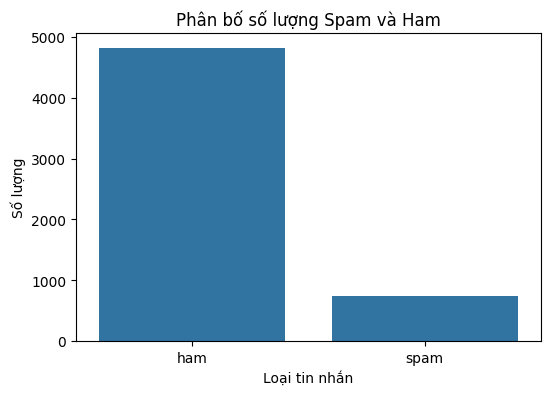

In [12]:
# 3. EDA Cơ bản

# Phân bố lớp (Spam vs. Ham)
print("\nPhân bố lớp Spam/Ham:")
print(df['Category'].value_counts())

plt.figure(figsize=(6, 4))
sns.countplot(x='Category', data=df)
plt.title('Phân bố số lượng Spam và Ham')
plt.xlabel('Loại tin nhắn')
plt.ylabel('Số lượng')
# Lưu biểu đồ (nếu muốn)
plt.savefig('../results/figures/class_distribution.png')
plt.show()


Thống kê độ dài tin nhắn:
count    5572.000000
mean       80.494975
std        60.000375
min         2.000000
25%        36.000000
50%        61.000000
75%       122.000000
max       910.000000
Name: Message_Length, dtype: float64


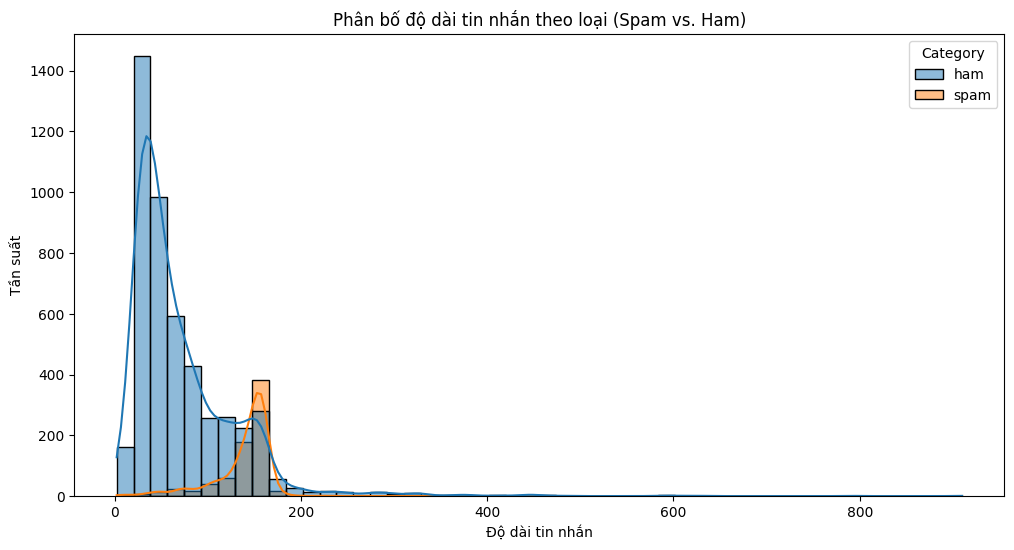

In [13]:
# Phân tích độ dài tin nhắn
df['Message_Length'] = df['Message'].apply(len)
print("\nThống kê độ dài tin nhắn:")
print(df['Message_Length'].describe())

plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='Message_Length', hue='Category', kde=True, bins=50)
plt.title('Phân bố độ dài tin nhắn theo loại (Spam vs. Ham)')
plt.xlabel('Độ dài tin nhắn')
plt.ylabel('Tần suất')
# plt.savefig('../results/figures/length_distribution.png')
plt.show()

In [14]:
# Xem xét các tin nhắn có độ dài bất thường (nếu cần)
print("\nTin nhắn dài nhất:")
print(df[df['Message_Length'] == df['Message_Length'].max()]['Message'].iloc[0])
print("\nTin nhắn ngắn nhất:")
print(df[df['Message_Length'] == df['Message_Length'].min()]['Message'].iloc[0])


Tin nhắn dài nhất:
For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later..

Tin nhắn ngắn nhất:
Ok


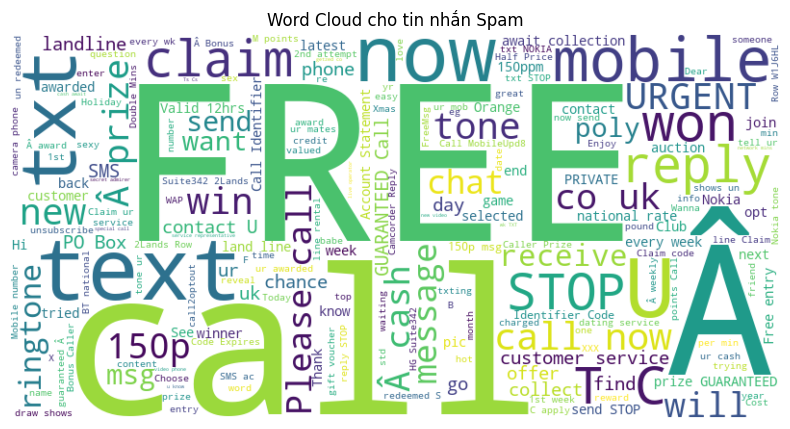

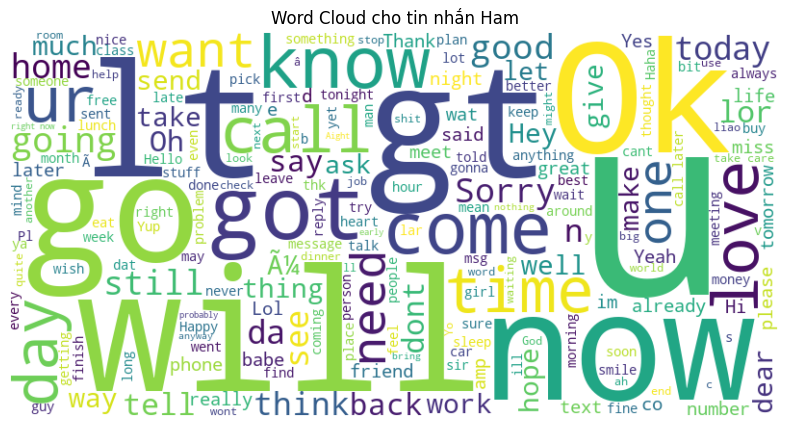

In [15]:
# (Tùy chọn) Word Cloud
try:
    from wordcloud import WordCloud

    spam_text = " ".join(df[df['Category'] == 'spam']['Message'])
    ham_text = " ".join(df[df['Category'] == 'ham']['Message'])

    # Word cloud cho Spam
    plt.figure(figsize=(10, 5))
    wordcloud_spam = WordCloud(width=800, height=400, background_color='white').generate(spam_text)
    plt.imshow(wordcloud_spam, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud cho tin nhắn Spam')
    plt.savefig('../results/figures/wordcloud_spam.png')
    plt.show()

    # Word cloud cho Ham
    plt.figure(figsize=(10, 5))
    wordcloud_ham = WordCloud(width=800, height=400, background_color='white').generate(ham_text)
    plt.imshow(wordcloud_ham, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud cho tin nhắn Ham')
    plt.savefig('../results/figures/wordcloud_ham.png')
    plt.show()

except ImportError:
    print("\nThư viện wordcloud chưa được cài đặt. Bỏ qua bước tạo Word Cloud.")
    print("Để cài đặt, chạy: pip install wordcloud")

In [16]:
# 4. Áp dụng Pipeline tiền xử lý v1

# Import hàm từ file src (đảm bảo file nằm đúng cấu trúc)
import sys
import os
# Thêm thư mục src vào đường dẫn để import
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.preprocess import clean_text_v1

print("\nÁp dụng tiền xử lý v1...")
# Tạo cột mới chứa tin nhắn đã làm sạch
df['Cleaned_Message'] = df['Message'].apply(clean_text_v1)

print("5 dòng đầu với Cleaned_Message:")
print(df[['Message', 'Cleaned_Message']].head())

# Xem thử một vài kết quả
print("\nVí dụ tiền xử lý:")
for i in range(5):
    print(f"Gốc : {df['Message'].iloc[i]}")
    print(f"Sạch: {df['Cleaned_Message'].iloc[i]}\n")

# Lưu lại DataFrame đã xử lý nếu muốn
# df.to_csv('../data/processed/spam_preprocessed_v1.csv', index=False)


Áp dụng tiền xử lý v1...
5 dòng đầu với Cleaned_Message:
                                             Message  \
0  Go until jurong point, crazy.. Available only ...   
1                      Ok lar... Joking wif u oni...   
2  Free entry in 2 a wkly comp to win FA Cup fina...   
3  U dun say so early hor... U c already then say...   
4  Nah I don't think he goes to usf, he lives aro...   

                                     Cleaned_Message  
0  go jurong point crazy available bugis n great ...  
1                            ok lar joking wif u oni  
2  free entry wkly comp win fa cup final tkts st ...  
3                u dun say early hor u c already say  
4        nah dont think goes usf lives around though  

Ví dụ tiền xử lý:
Gốc : Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Sạch: go jurong point crazy available bugis n great world la e buffet cine got amore wat

Gốc : Ok lar... Joking wif u oni...
Sạch: ok lar

\dtree Bắt đầu huấn luyện mô hình Decision Tree...
Kích thước tập huấn luyện: 4457
Kích thước tập kiểm tra: 1115

Kích thước ma trận TF-IDF tập huấn luyện: (4457, 5000)
Kích thước ma trận TF-IDF tập kiểm tra: (1115, 5000)

Đã huấn luyện xong mô hình Decision Tree.

Kết quả đánh giá Decision Tree (Baseline):
Accuracy: 0.9461883408071748

Confusion Matrix:
 [[942  24]
 [ 36 113]]

Classification Report:
               precision    recall  f1-score   support

         ham       0.96      0.98      0.97       966
        spam       0.82      0.76      0.79       149

    accuracy                           0.95      1115
   macro avg       0.89      0.87      0.88      1115
weighted avg       0.94      0.95      0.95      1115



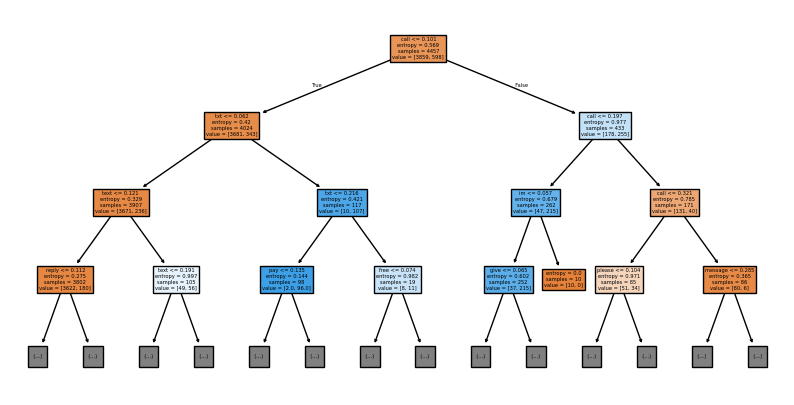

In [17]:
# 5. Bắt đầu triển khai Decision Tree (Baseline - sử dụng entropy)

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

print("\dtree Bắt đầu huấn luyện mô hình Decision Tree...")

# Dữ liệu đầu vào cho mô hình là cột Cleaned_Message
X = df['Cleaned_Message']
y = df['Category_Num'] # Nhãn dạng số (0 hoặc 1)

# Chia dữ liệu Train/Test (Tỷ lệ 80/20)
# Dùng random_state=42 để cả nhóm có kết quả chia giống nhau
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Kích thước tập huấn luyện: {X_train.shape[0]}")
print(f"Kích thước tập kiểm tra: {X_test.shape[0]}")

# Khởi tạo TF-IDF Vectorizer
# max_features giới hạn số lượng từ trong từ điển (tùy chọn, giúp giảm chiều dữ liệu)
tfidf_vectorizer = TfidfVectorizer(max_features=5000) # Bạn có thể thử nghiệm giá trị khác

# Fit và transform tập huấn luyện
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Chỉ transform tập kiểm tra (dùng từ điển đã học từ tập train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"\nKích thước ma trận TF-IDF tập huấn luyện: {X_train_tfidf.shape}")
print(f"Kích thước ma trận TF-IDF tập kiểm tra: {X_test_tfidf.shape}")

# Khởi tạo và huấn luyện mô hình Decision Tree
dtree_model = DecisionTreeClassifier(criterion = 'entropy')
dtree_model.fit(X_train_tfidf, y_train)

print("\nĐã huấn luyện xong mô hình Decision Tree.")

# Dự đoán trên tập kiểm tra
y_pred_dtree = dtree_model.predict(X_test_tfidf)

# Đánh giá ban đầu
print("\nKết quả đánh giá Decision Tree (Baseline):")
print("Accuracy:", accuracy_score(y_test, y_pred_dtree))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_dtree))
print("\nClassification Report:\n", classification_report(y_test, y_pred_dtree, target_names=['ham', 'spam']))

# (Tùy chọn) Lấy xác suất
# y_pred_proba_dtree = dtree_model.predict_proba(X_test_tfidf)
# print("\nXác suất dự đoán cho 5 mẫu đầu tiên:\n", y_pred_proba_dtree[:5])

from sklearn import tree
fig = plt.figure(figsize=(10,5))

_ = tree.plot_tree(dtree_model,filled = True, max_depth = 3, feature_names = tfidf_vectorizer.get_feature_names_out())

\dtree Bắt đầu huấn luyện mô hình Decision Tree...
Kích thước tập huấn luyện: 4457
Kích thước tập kiểm tra: 1115

Kích thước ma trận TF-IDF tập huấn luyện: (4457, 5000)
Kích thước ma trận TF-IDF tập kiểm tra: (1115, 5000)

Đã huấn luyện xong mô hình Decision Tree.

Kết quả đánh giá Decision Tree (Baseline):
Accuracy: 0.9479820627802691

Confusion Matrix:
 [[943  23]
 [ 35 114]]

Classification Report:
               precision    recall  f1-score   support

         ham       0.96      0.98      0.97       966
        spam       0.83      0.77      0.80       149

    accuracy                           0.95      1115
   macro avg       0.90      0.87      0.88      1115
weighted avg       0.95      0.95      0.95      1115



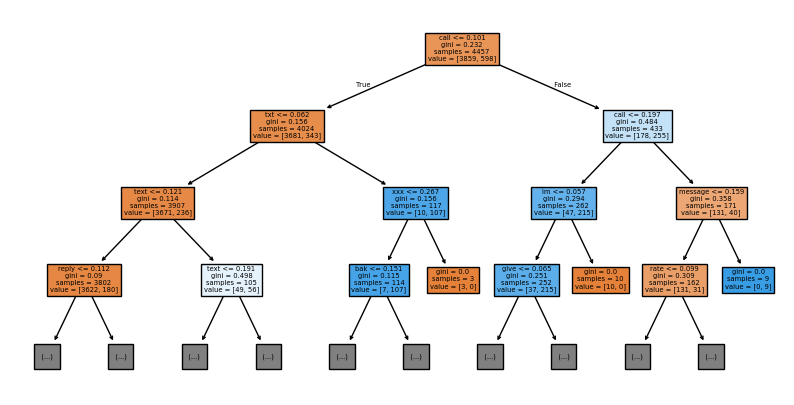

In [18]:
# 6. Triển khai Decision Tree (sử dụng gini)

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

print("\dtree Bắt đầu huấn luyện mô hình Decision Tree...")

# Dữ liệu đầu vào cho mô hình là cột Cleaned_Message
X = df['Cleaned_Message']
y = df['Category_Num'] # Nhãn dạng số (0 hoặc 1)

# Chia dữ liệu Train/Test (Tỷ lệ 80/20)
# Dùng random_state=42 để cả nhóm có kết quả chia giống nhau
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Kích thước tập huấn luyện: {X_train.shape[0]}")
print(f"Kích thước tập kiểm tra: {X_test.shape[0]}")

# Khởi tạo TF-IDF Vectorizer
# max_features giới hạn số lượng từ trong từ điển (tùy chọn, giúp giảm chiều dữ liệu)
tfidf_vectorizer = TfidfVectorizer(max_features=5000) # Bạn có thể thử nghiệm giá trị khác

# Fit và transform tập huấn luyện
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Chỉ transform tập kiểm tra (dùng từ điển đã học từ tập train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"\nKích thước ma trận TF-IDF tập huấn luyện: {X_train_tfidf.shape}")
print(f"Kích thước ma trận TF-IDF tập kiểm tra: {X_test_tfidf.shape}")

# Khởi tạo và huấn luyện mô hình Decision Tree
dtree_model = DecisionTreeClassifier(criterion = 'gini')
dtree_model.fit(X_train_tfidf, y_train)

print("\nĐã huấn luyện xong mô hình Decision Tree.")

# Dự đoán trên tập kiểm tra
y_pred_dtree = dtree_model.predict(X_test_tfidf)

# Đánh giá ban đầu
print("\nKết quả đánh giá Decision Tree (Baseline):")
print("Accuracy:", accuracy_score(y_test, y_pred_dtree))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_dtree))
print("\nClassification Report:\n", classification_report(y_test, y_pred_dtree, target_names=['ham', 'spam']))

# (Tùy chọn) Lấy xác suất
# y_pred_proba_dtree = dtree_model.predict_proba(X_test_tfidf)
# print("\nXác suất dự đoán cho 5 mẫu đầu tiên:\n", y_pred_proba_dtree[:5])

from sklearn import tree
fig = plt.figure(figsize=(10,5))

_ = tree.plot_tree(dtree_model,filled = True, max_depth = 3, feature_names = tfidf_vectorizer.get_feature_names_out())

In [20]:
import joblib

In [21]:
output_dir = '../results/trained_models/'
os.makedirs(output_dir, exist_ok=True)
joblib.dump(dtree_model, os.path.join(output_dir, 'best_random_forest_model.pkl'))
print("Đã lưu mô hình SVM tốt nhất.")

Đã lưu mô hình SVM tốt nhất.
